In [27]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [28]:
data = []
labels = []
file_name = []

# Loop melalui setiap subfolder (normal-cecum, polyps, ulcerative-colitis)
for sub_folder in os.listdir("dataset/"):
    sub_folder_path = os.path.join("dataset/", sub_folder)
    
    # Loop melalui setiap file gambar di subfolder
    for filename in os.listdir(sub_folder_path):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv2.imread(img_path) # Baca gambar
        if img is None:  # Skip jika gambar corrupt
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (512, 512)) #Resize gambar ke ukuran tetap agar bisa di-convert ke numpy array

        # Simpan ke list
        data.append(img_resized)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

        
data = np.array(data)
labels = np.array(labels)

In [29]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def median(imageCitra):
    sort_image = sorted(imageCitra.flatten())
    
    if(len(imageCitra.flatten()) % 2 == 0):
        index_median1 = len(imageCitra.flatten())/2 - 1
        index_median2 = len(imageCitra.flatten())/2 
        
        return (sort_image[index_median1] + sort_image[index_median2])/2
    else:
        index_median1 = len(imageCitra.flatten())//2
        
        return (sort_image[index_median1])
    
def filteringCitra(imageCitra, kernel_size, filter):
    citra_height, citra_width = imageCitra.shape
    pad = kernel_size // 2

    padded_image = np.pad(imageCitra, pad_width=pad, mode='edge')

    result = np.zeros((citra_height, citra_width))

    for i in range(citra_height):
        for j in range(citra_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            if(filter == "mean"):
                result[i][j] = np.sum(region)/(kernel_size*kernel_size)
            elif(filter == "modus"):
                result[i][j] = modus(region)
            elif(filter == "median"):
                result[i][j] = median(region)
                
    return result

kernel_tajam = np.array([[1/9,1/9,1/9],
                         [1/9,8/9,1/9],
                         [1/9,1/9,1/9]])

def convo(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result

def thresholding(imageCitra, threshold, min_val, max_val):
    imageCitra = imageCitra.astype(np.uint8)
    result = np.where(imageCitra <= threshold, max_val, min_val).astype(np.uint8)
    
    return result

def dilasi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.any(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def erosi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.all(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def opening(gambar, kernel):
    eroded = erosi(gambar, kernel)
    opened = dilasi(eroded, kernel)
    return opened.astype(np.uint8)

def closing(gambar, kernel):
    dilated = dilasi(gambar, kernel)
    closed = erosi(dilated, kernel)
    return closed.astype(np.uint8)

def maskerImage(channel, mask_median):
    objek = channel.copy()
    objek[mask_median == 0] = 0 

    return objek

In [54]:
def preprocess_1(img):
    # img_equalized = histogram_equalization(img)
    img_median = filteringCitra(img, kernel_size=3, filter="median")   
    img_tresh = thresholding(img_median, 120, 255, 0)
    return img_tresh

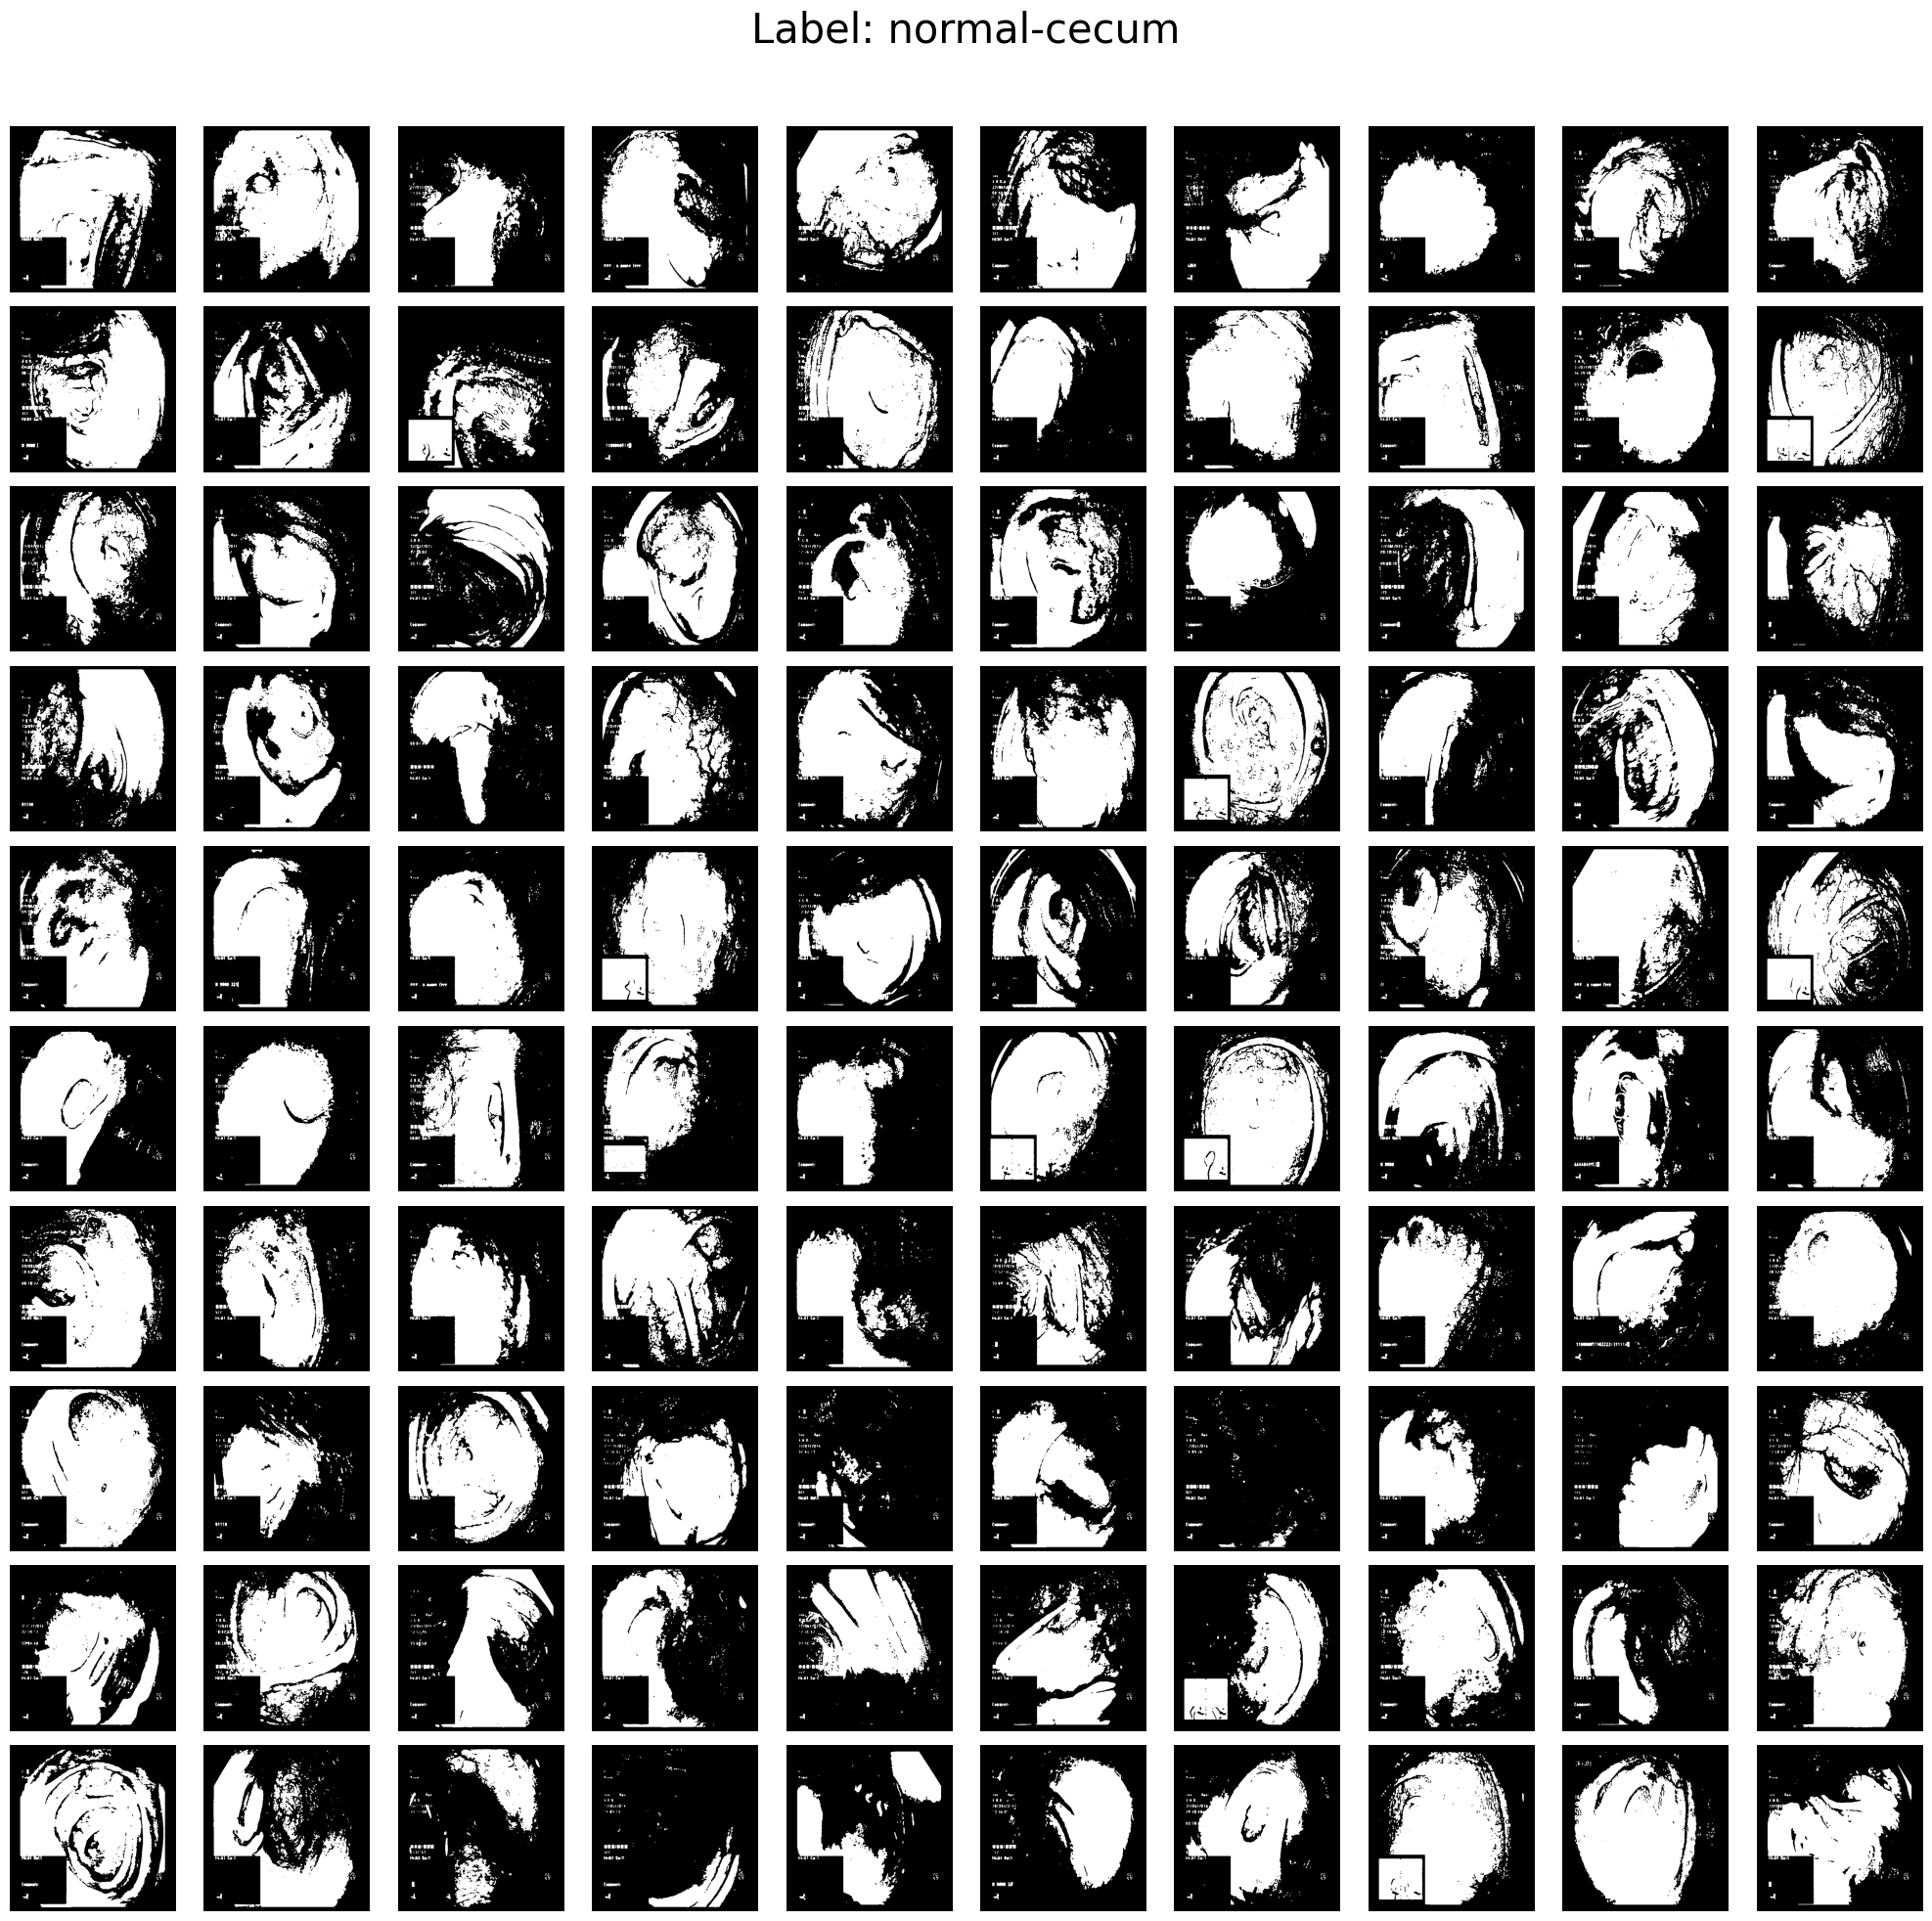

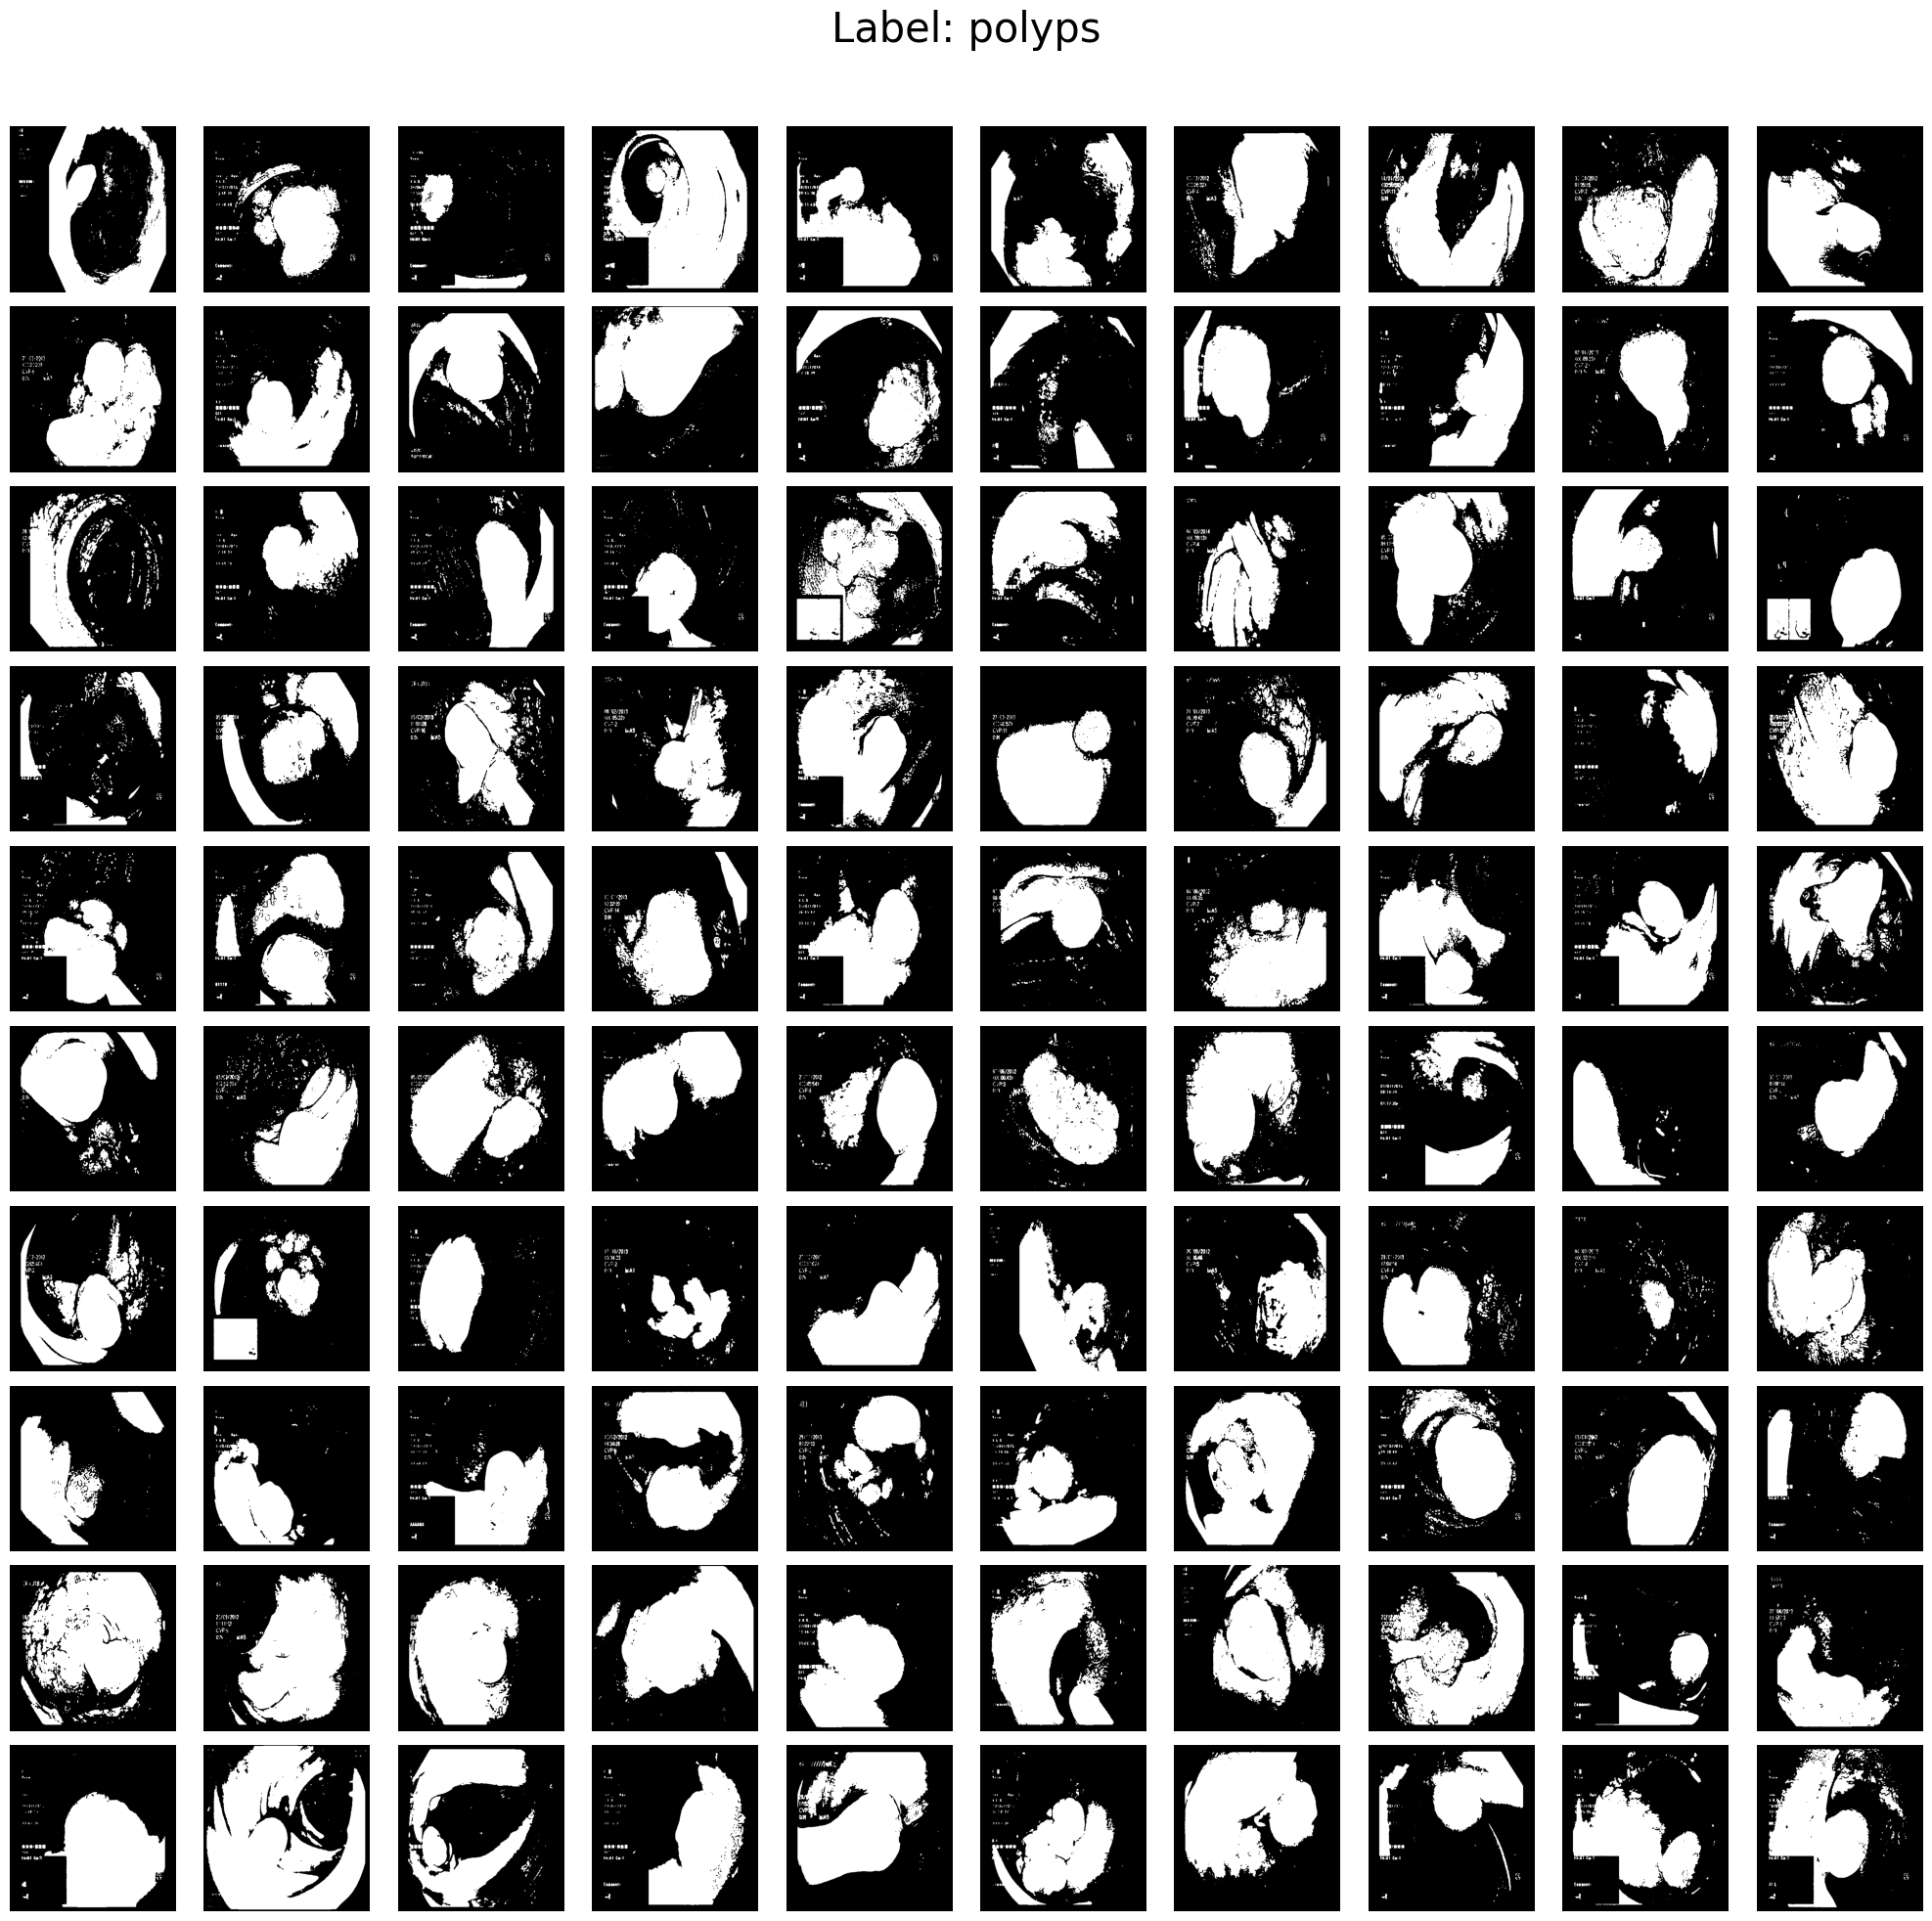

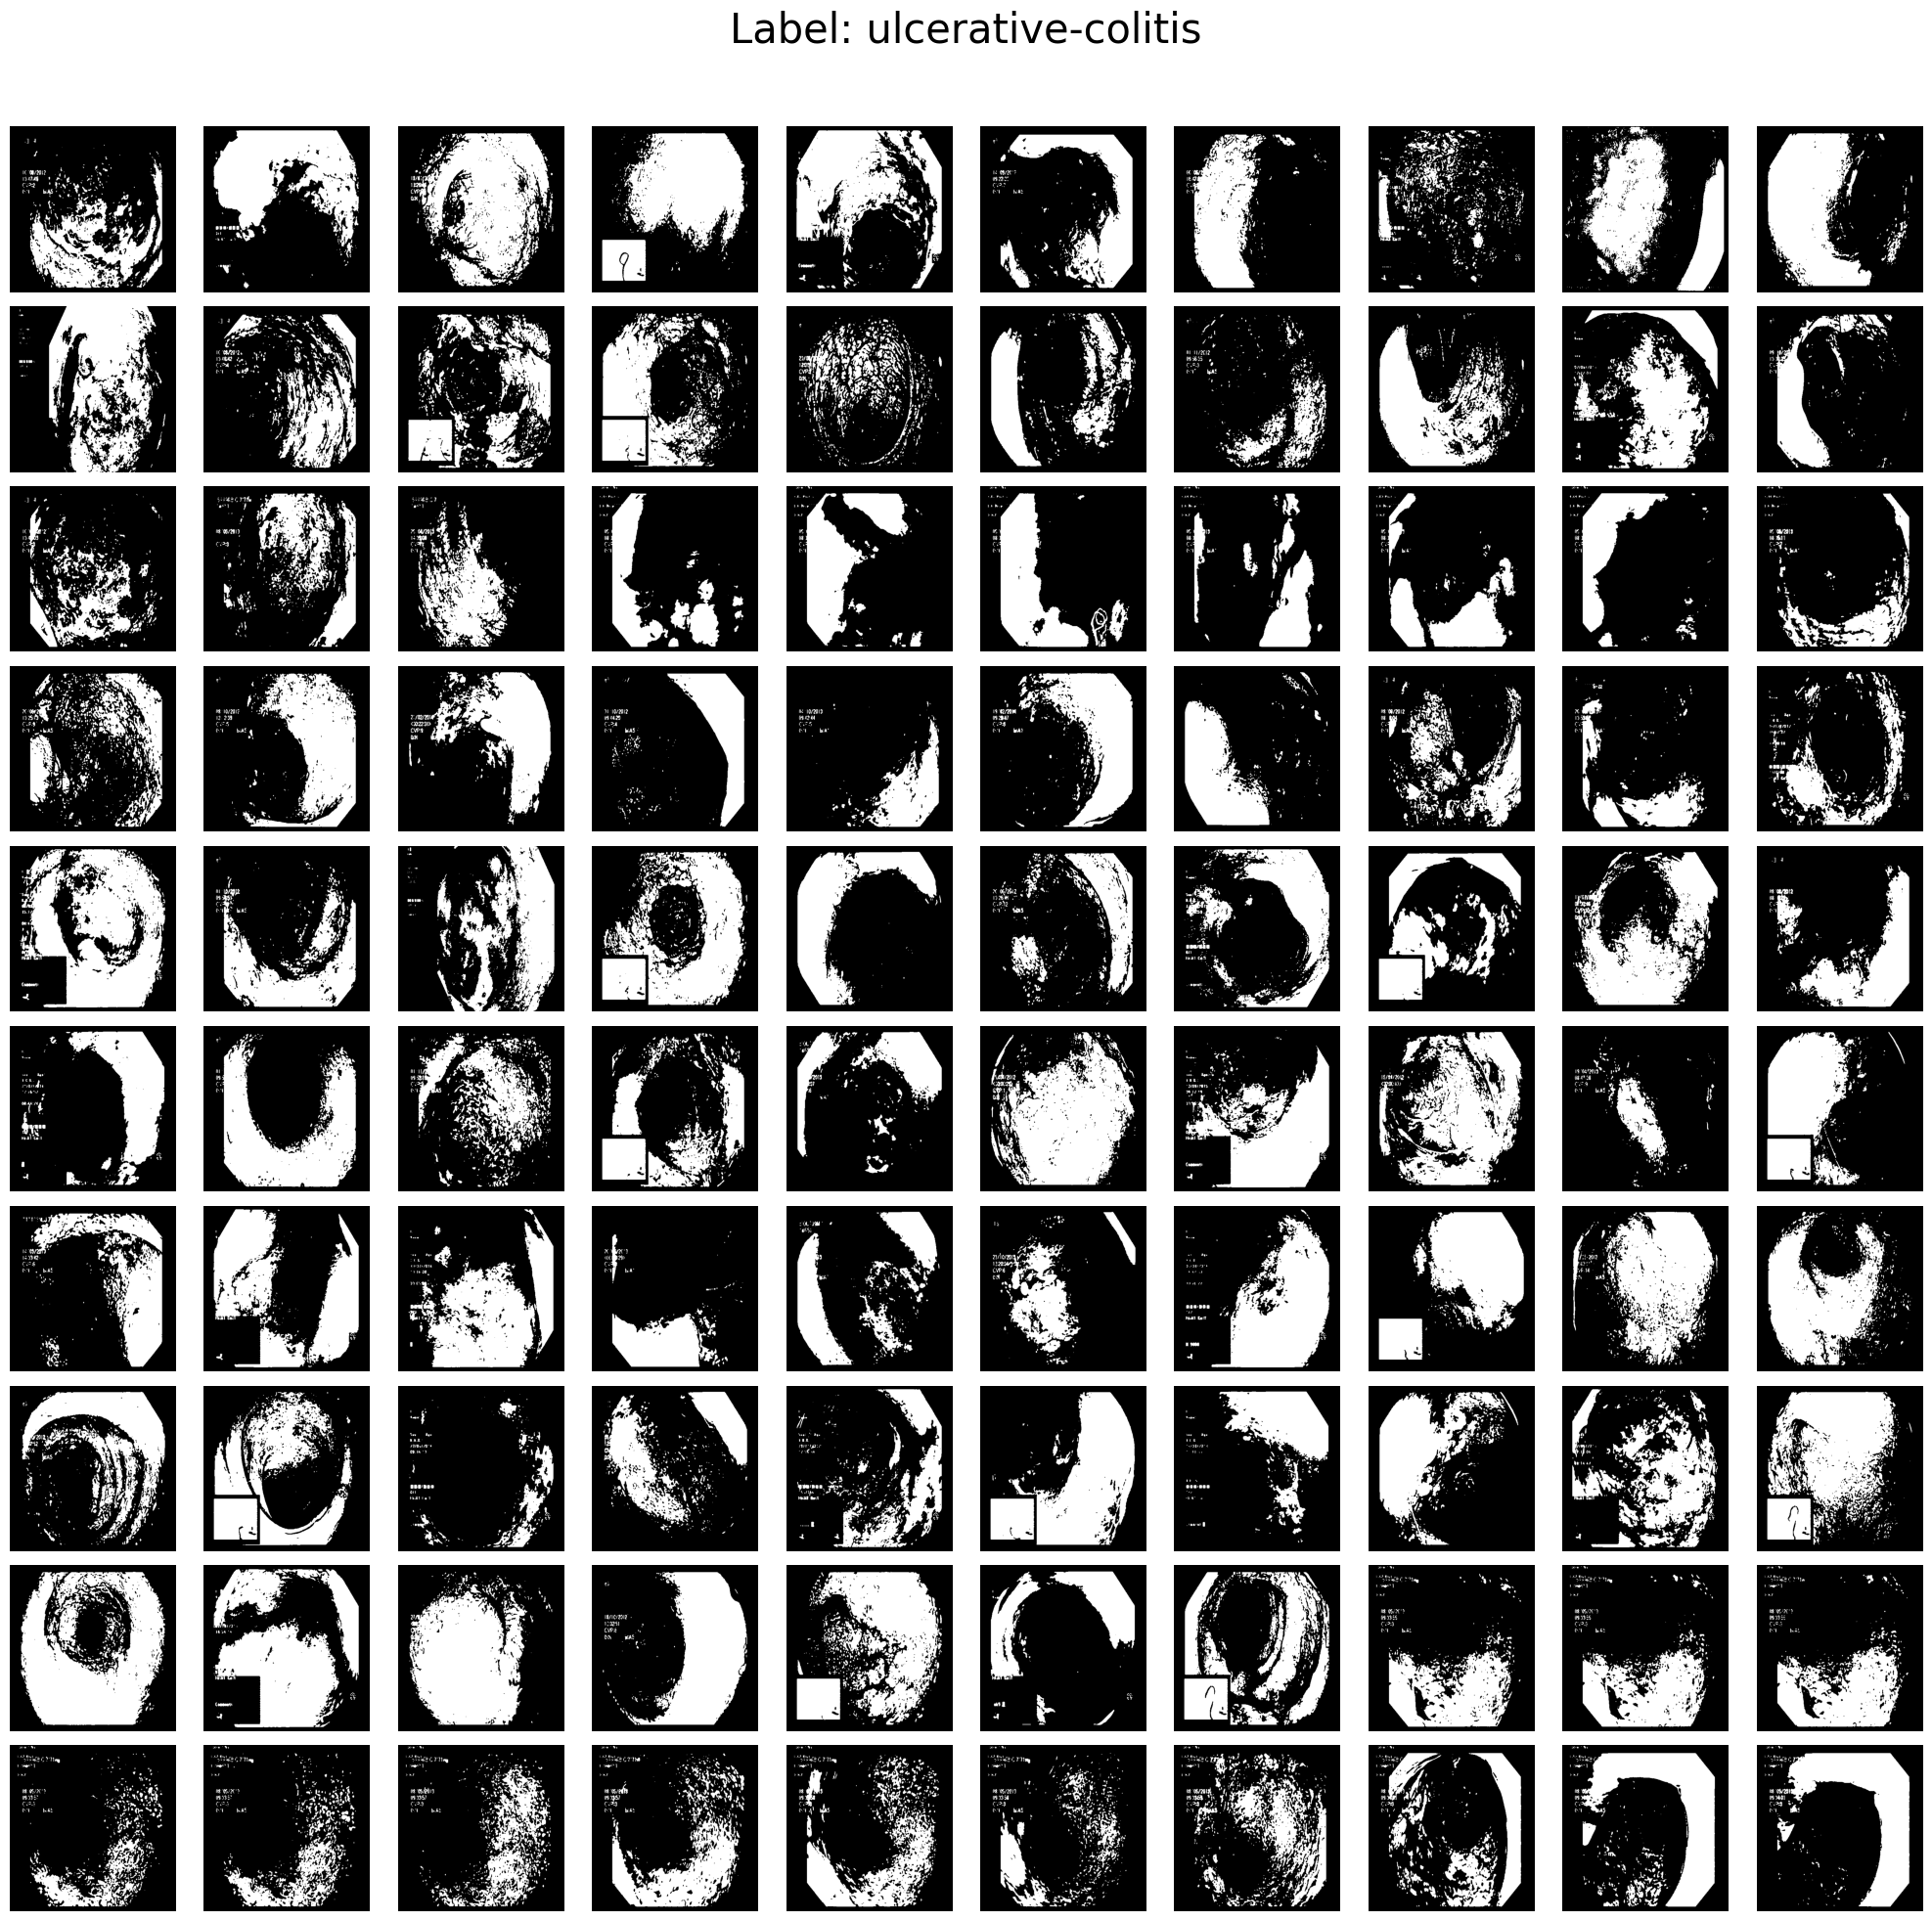

In [55]:
dataPreprocessed1 = [preprocess_1(img) for img in data] 
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
	
    # Buat grid 10x10 (cukup untuk 100 gambar, 10*10 = 100)
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))
    fig.suptitle(f'Label: {label}', fontsize=30)
    
    for k in range(100):
        row = k // 10
        col = k % 10
        ax = axs[row][col]
        ax.imshow(dataPreprocessed1[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [32]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [33]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed1)):
    D0 = glcm(dataPreprocessed1[i], 0)
    D45 = glcm(dataPreprocessed1[i], 45)
    D90 = glcm(dataPreprocessed1[i], 90)
    D135 = glcm(dataPreprocessed1[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [34]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [35]:
for i in range(len(dataPreprocessed1)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [36]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [37]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [38]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [39]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [40]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [41]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [42]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

Filename               Label  \
0             00f3d2cc-93ea-40f0-9b88-b159b07a49cb.jpg        normal-cecum   
1             01c49663-9674-44ae-b61e-05243a30e4ab.jpg        normal-cecum   
2             01e023db-5c76-4c28-91ab-06e36cd31495.jpg        normal-cecum   
3             02dcedf1-c0bd-4ef4-b072-ea8f11da6a1d.jpg        normal-cecum   
4             032a3076-c75c-4089-a57c-1b19e5f6589e.jpg        normal-cecum   
..                                                 ...                 ...   
295  fc79c489-b358-4368-b965-330615af73d4_00000332.jpg  ulcerative-colitis   
296  fc79c489-b358-4368-b965-330615af73d4_00000351.jpg  ulcerative-colitis   
297  fc79c489-b358-4368-b965-330615af73d4_00000403.jpg  ulcerative-colitis   
298  fc79c489-b358-4368-b965-330615af73d4_00000411.jpg  ulcerative-colitis   
299  fc79c489-b358-4368-b965-330615af73d4_00000413.jpg  ulcerative-colitis   

       Contrast0   Contrast45   Contrast90  Contrast135  Homogeneity0  \
0    1283.937554  1825.832851  1185.020181  1721.741453      0.980255   
1    1239.698126  1691.858755  1094.055964  1654.007338      0.980935   
2     650.667541   903.453571   570.141840   884.527863      0.989994   
3    1056.775547  1398.012224   885.285630  1412.455528      0.983748   
4    1499.169826  2196.378307  1490.719599  2035.011738      0.976945   
..           ...          ...          ...          ...           ...   
295  2346.677968  2970.340187  1764.109321  2901.111937      0.963912   
296  2568.372179  3238.786425  1906.271977  3148.142241      0.960502   
297  2711.031907  3381.725330  1923.172433  3245.759054      0.958308   
298  2087.206267  2609.755631  1544.403399  2618.222395      0.967902   
299  1951.505550  2443.906656  1453.936254  2497.197468      0.969989   

     Homogeneity45  Homogeneity90  Homogeneity135  ...     ASM90    ASM135  \
0         0.971921       0.981776        0.973522  ...  0.491043  0.483457   
1         0.973982       0.983175        0.974564  ...  0.487051  0.478986   
2         0.986106       0.991232        0.986397  ...  0.493558  0.488974   
3         0.978501       0.986386        0.978279  ...  0.489392  0.481732   
4         0.966223       0.977075        0.968705  ...  0.493160  0.485652   
..             ...            ...             ...  ...       ...       ...   
295       0.954321       0.972871        0.955385  ...  0.475883  0.459795   
296       0.950192       0.970684        0.951586  ...  0.473943  0.456477   
297       0.947994       0.970425        0.950085  ...  0.473399  0.454814   
298       0.959866       0.976249        0.959736  ...  0.478943  0.463625   
299       0.962416       0.977641        0.961597  ...  0.480225  0.465293   

      Energy0  Energy45  Energy90  Energy135  Correlation0  Correlation45  \
0    0.699699  0.694221  0.700744   0.695310      0.959791       0.942786   
1    0.696341  0.691689  0.697890   0.692088      0.961594       0.947567   
2    0.701672  0.699064  0.702537   0.699267      0.979897       0.972079   
3    0.697735  0.694222  0.699566   0.694069      0.967312       0.956743   
4    0.702165  0.695221  0.702254   0.696888      0.952408       0.930216   
..        ...       ...       ...        ...           ...            ...   
295  0.683733  0.677368  0.689843   0.678082      0.927492       0.908196   
296  0.681514  0.674700  0.688435   0.675631      0.920623       0.899873   
297  0.679814  0.673005  0.688040   0.674399      0.916264       0.895519   
298  0.686339  0.680988  0.692057   0.680900      0.935528       0.919365   
299  0.687731  0.682678  0.692983   0.682124      0.939725       0.924496   

     Correlation90  Correlation135  
0         0.962889        0.946047  
1         0.966106        0.948740  
2         0.982385        0.972663  
3         0.972616        0.956296  
4         0.952677        0.935343  
..             ...             ...  
295       0.945492        0.910335  
296       0.941085        0.902676  
297       0.940599        0.899720  


<Axes: >

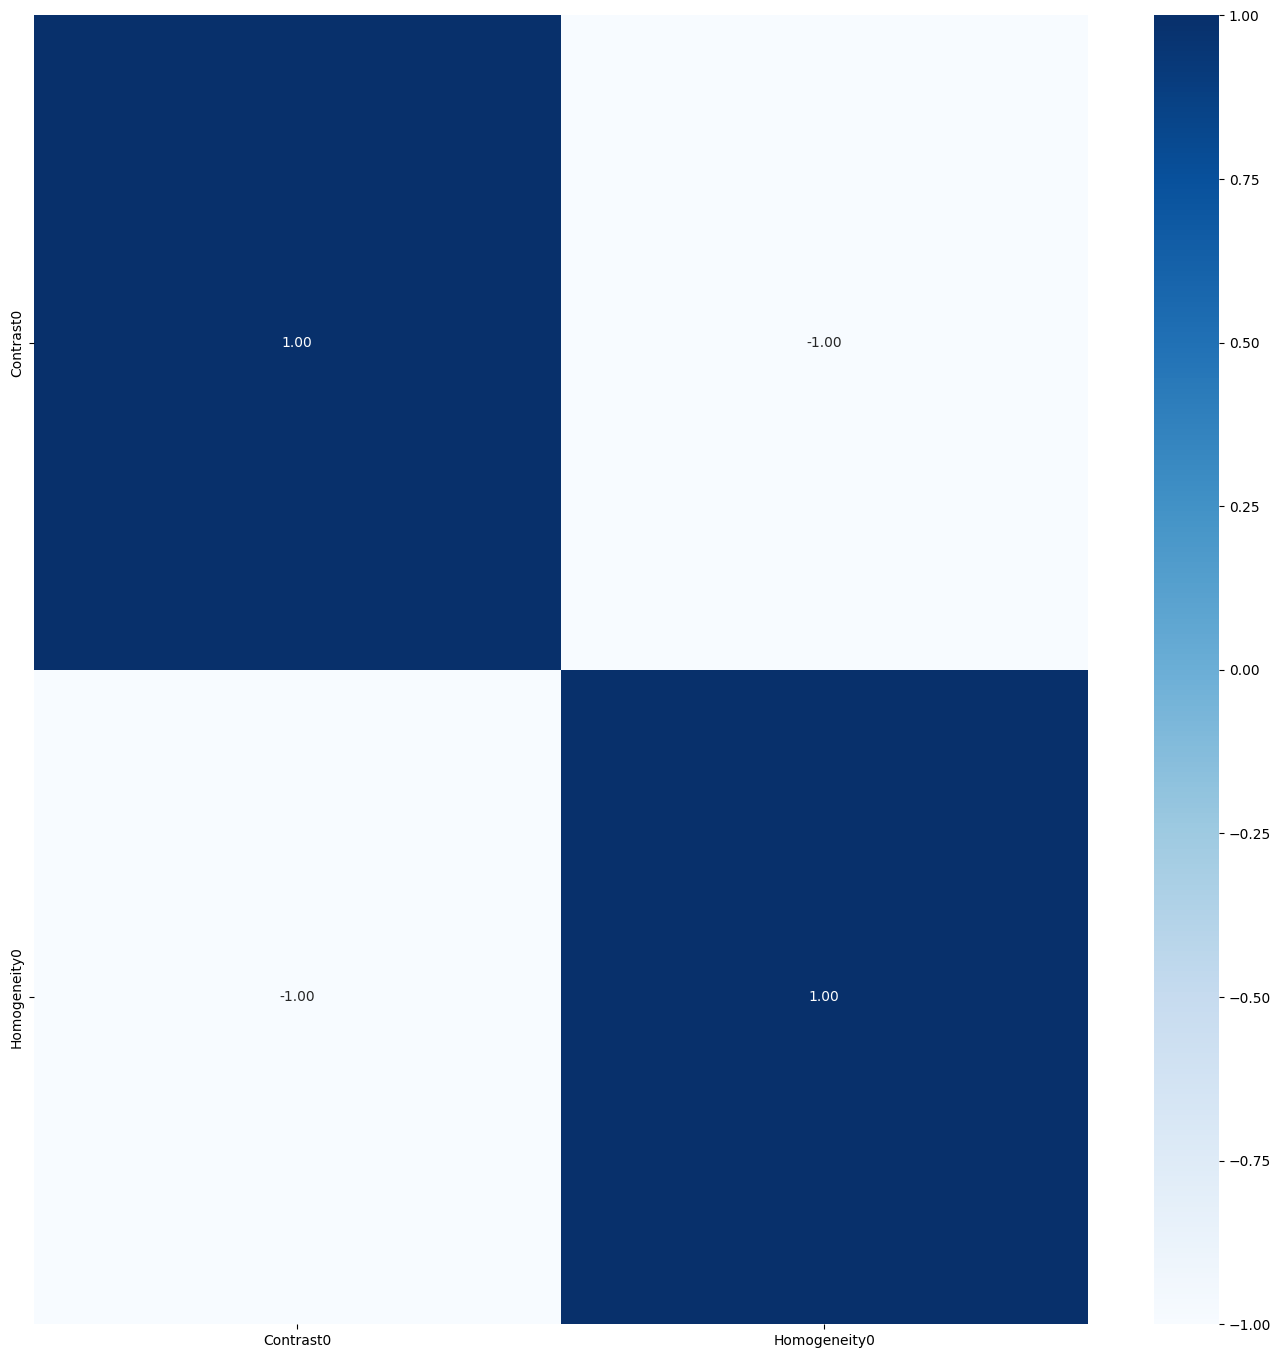

In [43]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [44]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(240, 2)
(60, 2)


In [45]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [46]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [47]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.88      0.86      0.87        78
            polyps       0.88      0.92      0.90        84
ulcerative-colitis       0.91      0.88      0.90        78

          accuracy                           0.89       240
         macro avg       0.89      0.89      0.89       240
      weighted avg       0.89      0.89      0.89       240

[[67  6  5]
 [ 5 77  2]
 [ 4  5 69]]
Accuracy: 0.8875

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.53      0.45      0.49        22
            polyps       0.40      0.62      0.49        16
ulcerative-colitis       0.56      0.41      0.47        22

          accuracy                           0.48        60
         macro avg       0.50      0.50      0.48        60
      weighted avg       0.51      0.48      0.48        60

[[10  8  4]
 [ 3 10  3]
 [ 6  7  9]]
Accuracy: 0.4

In [48]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.39      0.46      0.42        78
            polyps       0.52      0.60      0.56        84
ulcerative-colitis       0.71      0.47      0.57        78

          accuracy                           0.51       240
         macro avg       0.54      0.51      0.52       240
      weighted avg       0.54      0.51      0.52       240

[[36 31 11]
 [30 50  4]
 [26 15 37]]
Accuracy: 0.5125

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.43      0.45      0.44        22
            polyps       0.60      0.75      0.67        16
ulcerative-colitis       0.59      0.45      0.51        22

          accuracy                           0.53        60
         macro avg       0.54      0.55      0.54        60
      weighted avg       0.54      0.53      0.53        60

[[10  6  6]
 [ 3 12  1]
 [10  2 10]]
Accuracy: 0.

In [49]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.50      0.72      0.59        78
            polyps       0.63      0.60      0.61        84
ulcerative-colitis       0.77      0.47      0.59        78

          accuracy                           0.60       240
         macro avg       0.63      0.60      0.60       240
      weighted avg       0.63      0.60      0.60       240

[[56 13  9]
 [32 50  2]
 [25 16 37]]
Accuracy: 0.5958333333333333

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.56      0.64      0.60        22
            polyps       0.45      0.62      0.53        16
ulcerative-colitis       0.69      0.41      0.51        22

          accuracy                           0.55        60
         macro avg       0.57      0.56      0.55        60
      weighted avg       0.58      0.55      0.55        60

[[14  4  4]
 [ 6 10  0]
 [ 5  8  9]]


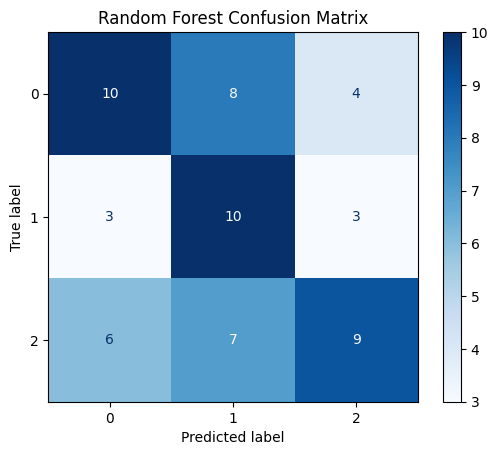

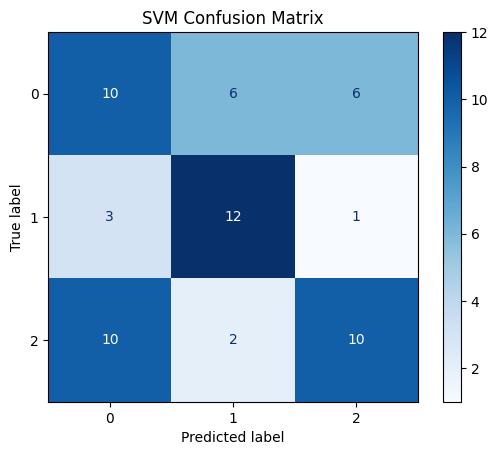

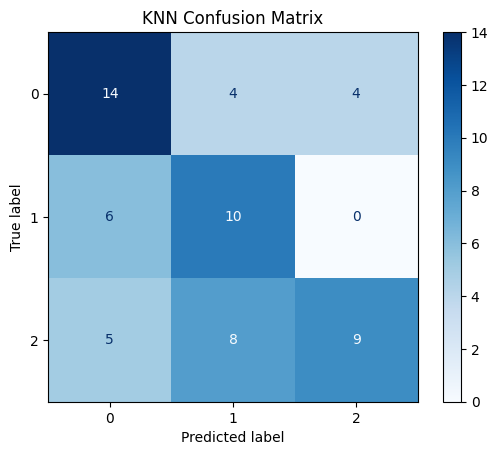

In [50]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")